# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [35]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%run functions.py

We first ran the standard delta-hedging method against the Heston model. Increasing the number of hedges did not significantly improve the performance of the portfolio.

Monte-Carlo Simulated value of Call Option, Heston Model: $21.91     with standard error 0.062703.


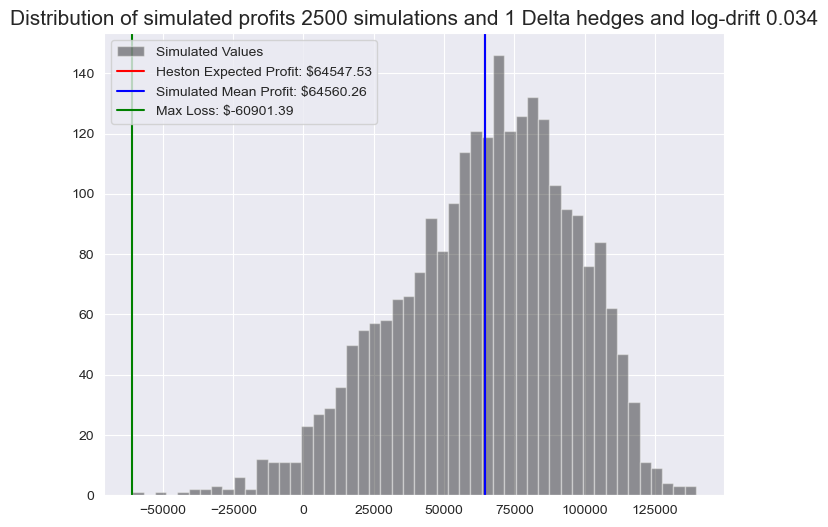

Monte-Carlo Simulated value of Call Option, Heston Model: $21.91     with standard error 0.062772.


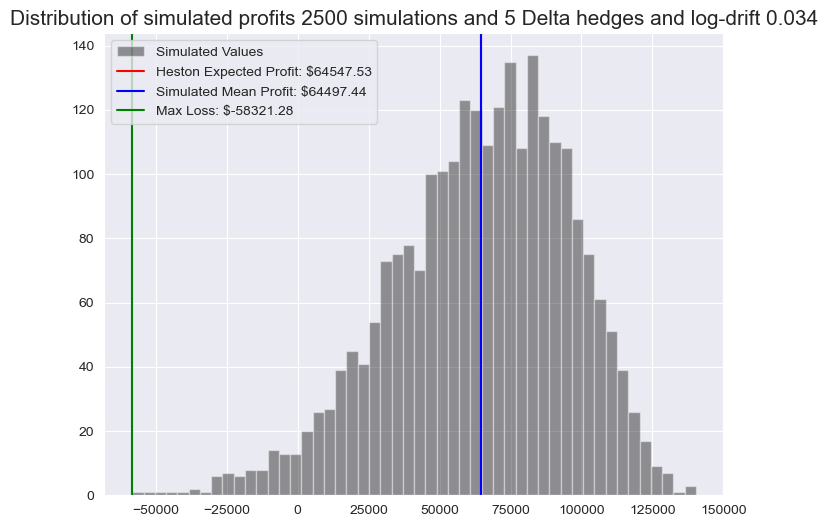

Monte-Carlo Simulated value of Call Option, Heston Model: $21.91     with standard error 0.061058.


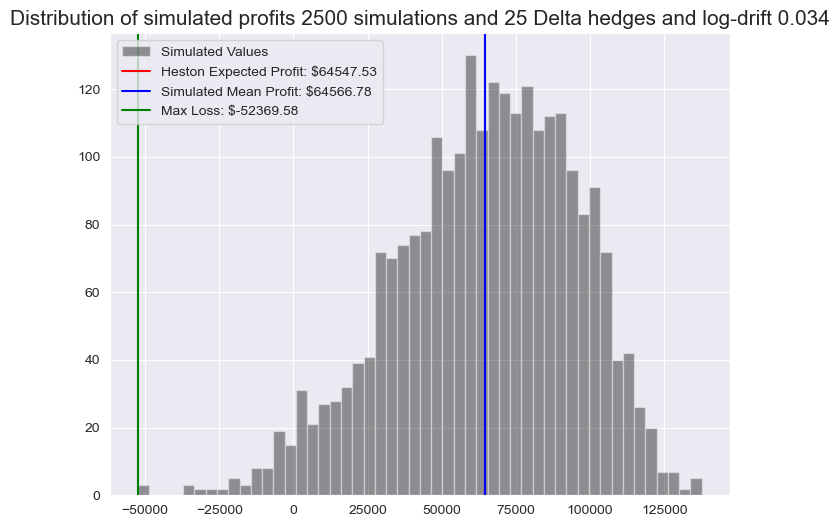

Monte-Carlo Simulated value of Call Option, Heston Model: $21.96     with standard error 0.062721.


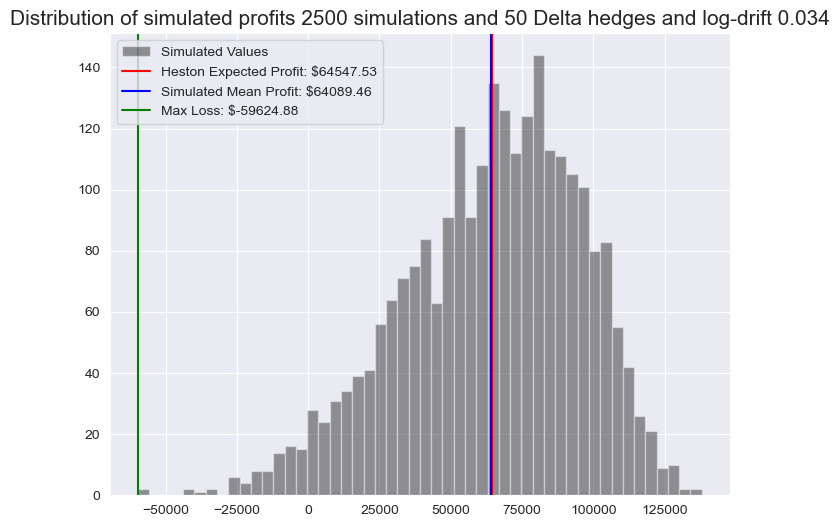

Monte-Carlo Simulated value of Call Option, Heston Model: $21.86     with standard error 0.060447.


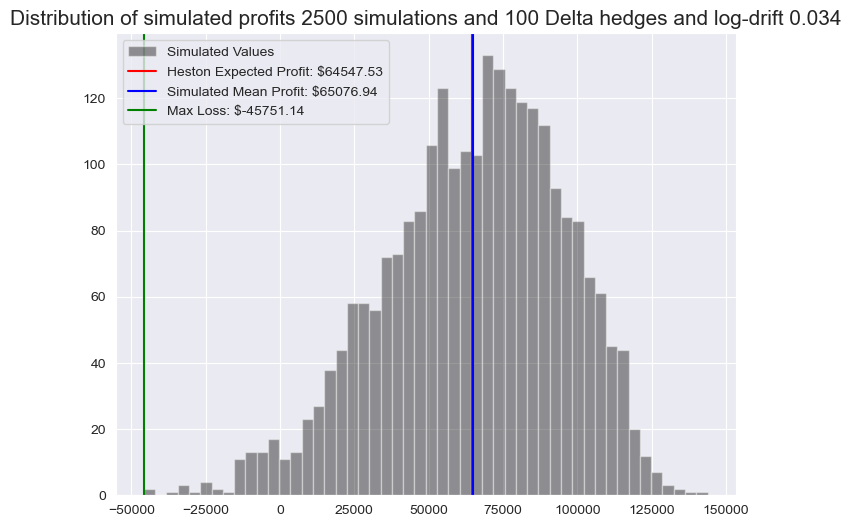

Monte-Carlo Simulated value of Call Option, Heston Model: $22.05     with standard error 0.062168.


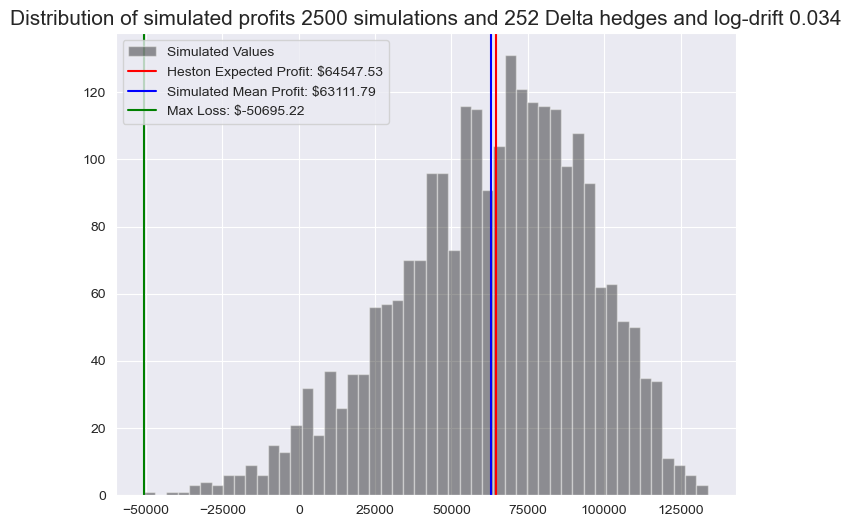

Monte-Carlo Simulated value of Call Option, Heston Model: $21.84     with standard error 0.059920.


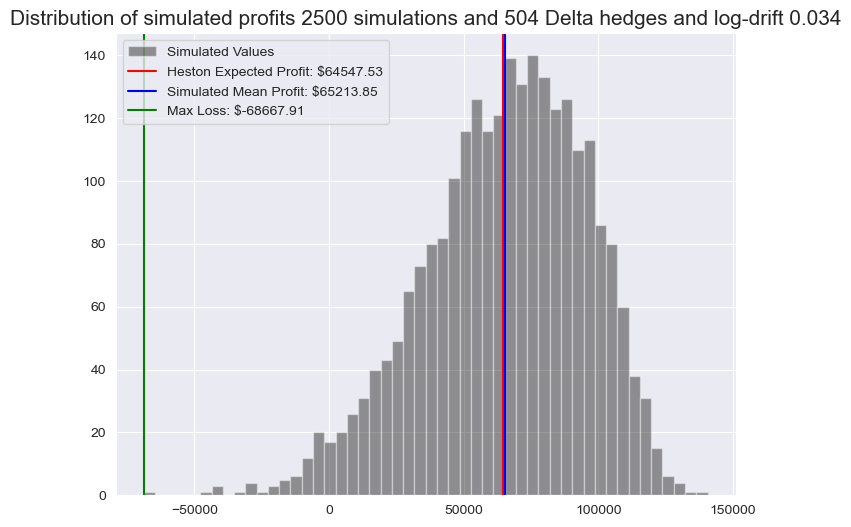

In [36]:
#Monte-Carlo method to simulate price of call option under Heston-Model.
#Compare estimate provided by faster method of numeric integration.

### Visual of stock paths measure simulated through the Heston model


#Heston parameters
kappa = 1 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)
theta = .5**2 #Long run variance of log-returns
xi = .5 # Volatility of Volatility (Typical range .2 to 1)
v0 = .3**2 #Initial variance of log-returns
rho = -.5 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)
S0 = 100 #Initial Stock Value
t = 1 #Time horizon
n_steps = 252 #Number of steps in each simulation
r = .04 #Risk-free interest rate
n_sims = 2500 #Number of simulations
mu = .034 #Excess drift of log returns

K = 90 #Strike Price 1

#premium = heston_call_MC_price(S0, K, v0+0.3, r, t, kappa, theta, xi, rho)
premium = heston_call(S0, K, v0+0.3, r, t, kappa, theta, xi, rho)

#Increased volatility results in higher price in Black-Scholes model
num_options = 10000


#heston_price = heston_call_MC_price(S0, K, v0, r, t, kappa, theta, xi, rho, n_sims=25000)
heston_price = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)

n_sims = 2500

hedging_numbers = [1, 5, 25, 50, 100, 252, 2*252]

for n_hedges in hedging_numbers:
    sold_calls_hedged =  heston_call_MC(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu=0)
    
    profits_hedged = num_options*(premium - sold_calls_hedged)
    
    heston_call_sim = np.mean(np.mean(sold_calls_hedged))
    heston_std_err = np.std(sold_calls_hedged)/np.sqrt(n_sims)
    print(f'Monte-Carlo Simulated value of Call Option, Heston Model: ${heston_call_sim:.2f}\
     with standard error {heston_std_err:.6f}.')
    
    plt.figure(figsize = (8,6))
    
    plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
    
    plt.axvline(num_options*(premium-heston_price), label = f'Heston Expected Profit: ${num_options*(premium-heston_price):.2f}', color = 'red')
    
    plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
    plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')
    
    plt.legend()
    
    plt.title(f'Distribution of simulated profits {n_sims} simulations and {n_hedges} Delta hedges and log-drift {mu}',size = 15)
    
    plt.show()


Vega is given by

$\nu = S\sqrt{\tau}N'(d_1)$.

A strategy to hedge vega and delta, given in http://www.thierry-roncalli.com/download/stochvol.pdf, is to use two call options $C_1$ and $C_2$, say at strike prices $K_1$ and $K_2$. If we take

$\alpha = \nu_1/\nu_2 = N'(d_1^1)/N'(d_1^2)$,

where $d_1^i$ is the $d_1$ value corresponding to call option $C_i$, then $C_1-\alpha C_2$ becomes vega-neutral. To make this Delta neutral as well, we consider the portfolio

$C_1-\alpha C_2 -(\Delta_1-\alpha \Delta_2)S=(C_1-\Delta_1S)-\alpha(C_2-\Delta_2S)$.

For ease of computation, we chose the case where $d_1^2=d_2^1$, namely $d_1^2$ is the corresponding $d_2$ value for option $C_1$. Solving this gives $\alpha= K_1e^{-r\tau}/S$ and $K_2=K_1e^{\sigma^2\tau}$.

To implement this strategy, we first modified the heston_call function to accommodate for array entries for $S0$, $K$, and $v0$.

In [37]:
def heston_call_array(S0, K, v0, r, t, kappa, theta, xi, rho):
    """
    Price of a call option under Heston model
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions

    Returns:
    - call_price (float): Call option price
    """
    if t>0.00000001:
        l=len(S0)
        def integrand(phi, Pnum,j):
            i = complex(0, 1)
            u = 0.5 if Pnum == 1 else -0.5
            b = kappa - rho * xi if Pnum == 1 else kappa
            a = kappa * theta
            d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
            g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)
            
            exp1 = np.exp(i * phi * np.log(S0[j] / K[j]))
            C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
            D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
            f = exp1 * np.exp(C + D * v0[j])
            return np.real(f / (phi * i))
    
        P1 = [0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1,i), 0, 100)[0] for i in range(l)]
        P2 = [0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2,i), 0, 100)[0] for i in range(l)]
        call_price = S0 * P1 - K * np.exp(-r * t) * P2
        return call_price
    else:
        return np.maximum(S0-K,0)

Now we implement the above vega hedging strategy.

In [43]:
def heston_call_vega_hedge_MC(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=2500, mu=0):
    """
    Monte-Carlo Simulation of Call Option under Heston model with Black-Scholes Delta and Vega control variates
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - call_payouts (ndarray): Simulated payouts of a call-option
    """
    
    
    paths, vols = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu, return_vol=True)
    
    dt = t / n_steps


    #First compute the alpha coefficients according to above formula
    alphas = np.array([K*np.exp(-r*(t-i*dt))/paths[:,i] for i in range(n_steps)]).T
    
    #Next compute the delta values to obtain delta=delta1-alpha*delta2
    deltas_1 = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T
    deltas_2 = np.array([bs_call_delta(paths[:, i], K*np.exp(vols[:,i]*(t-i*dt)), np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T
    deltas = deltas_1-alphas*deltas_2
    
    
    # Stock P&L from delta hedge
    stock_profits_steps = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * deltas * np.exp(-r * np.arange(1, n_steps + 1) * dt)
    stock_profits = np.sum(stock_profits_steps, axis=1)
    
    # Call option P&L from vega hedge
    options = np.array([heston_call_array(paths[:,i], K*np.exp(vols[:,i]*(t-i*dt)),  np.sqrt(vols[:,i]), r, t-i*dt, kappa, theta, xi, rho) for i in range(n_steps+1)]).T
    #options = np.array([np.mean(heston_path_sim(paths[:,i],  np.sqrt(vols[:,i]), r, t-i*dt, kappa, theta, xi, rho))-K*np.exp(vols[:,i]*(t-i*dt)) for i in range(n_steps+1)]).T
    call_profits_steps = (options[:, 1:] - np.exp(r*dt)*options[:, :-1]) * alphas * np.exp(-r * np.arange(1, n_steps + 1) * dt)
    call_profits = np.sum(call_profits_steps, axis=1)

    # Call payouts
    call_payouts = np.maximum(paths[:, -1] - K,0) * np.exp(-r * t)

    # Adjusted estimator
    call_payouts_hedged = call_payouts - stock_profits - call_profits
    return call_payouts_hedged

Standard error of Monte-Carlo simulated value of portfolio for Heston model: 0.055303.


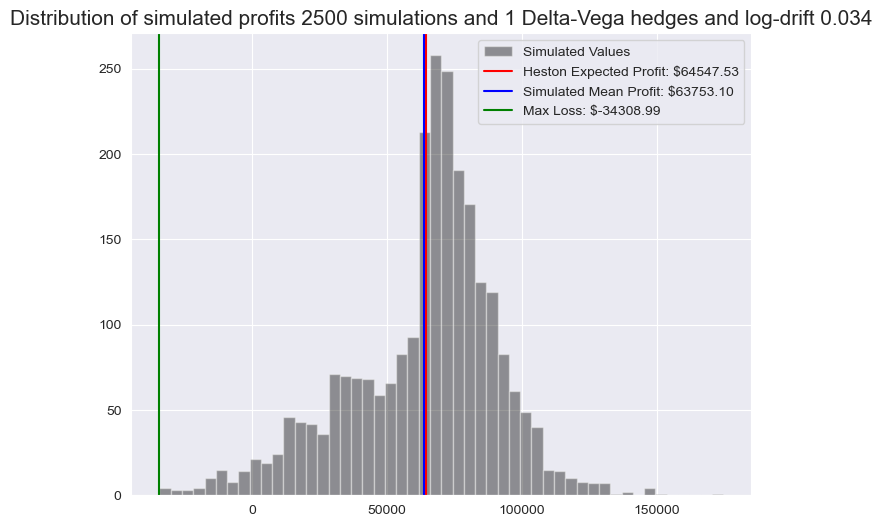

Standard error of Monte-Carlo simulated value of portfolio for Heston model: 0.077571.


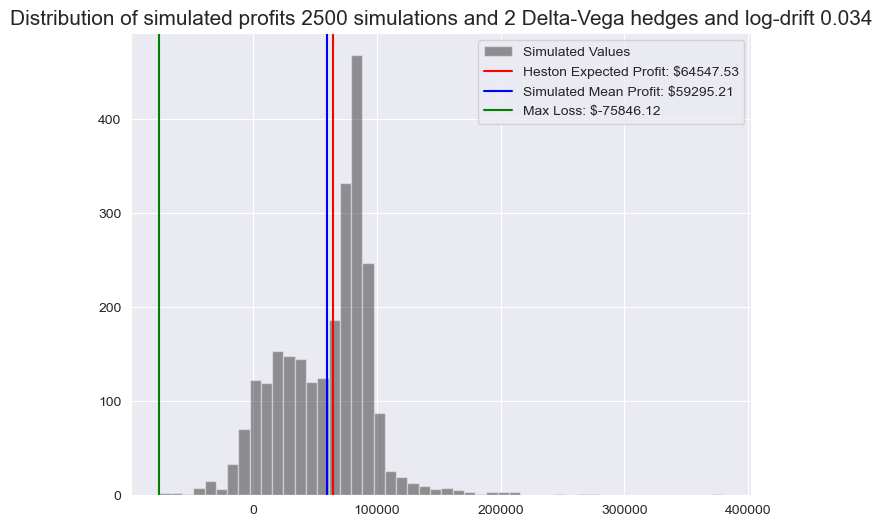

Standard error of Monte-Carlo simulated value of portfolio for Heston model: 0.069084.


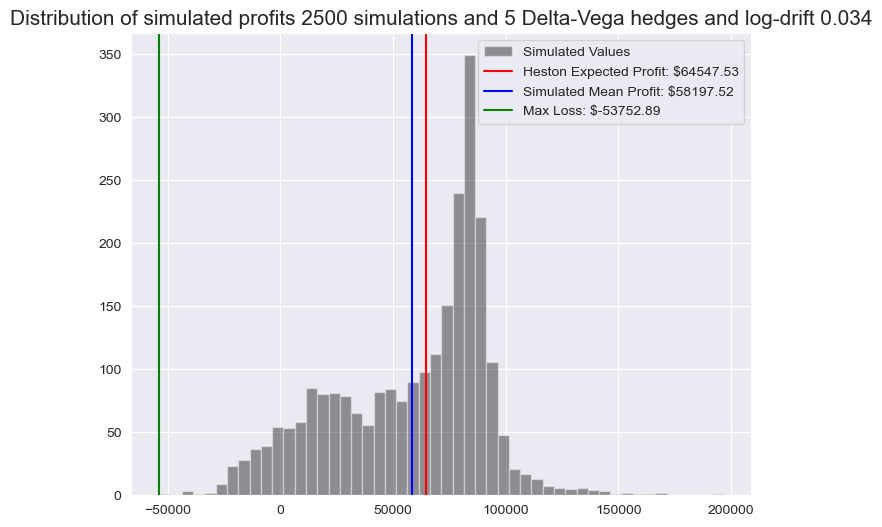

Standard error of Monte-Carlo simulated value of portfolio for Heston model: 0.064431.


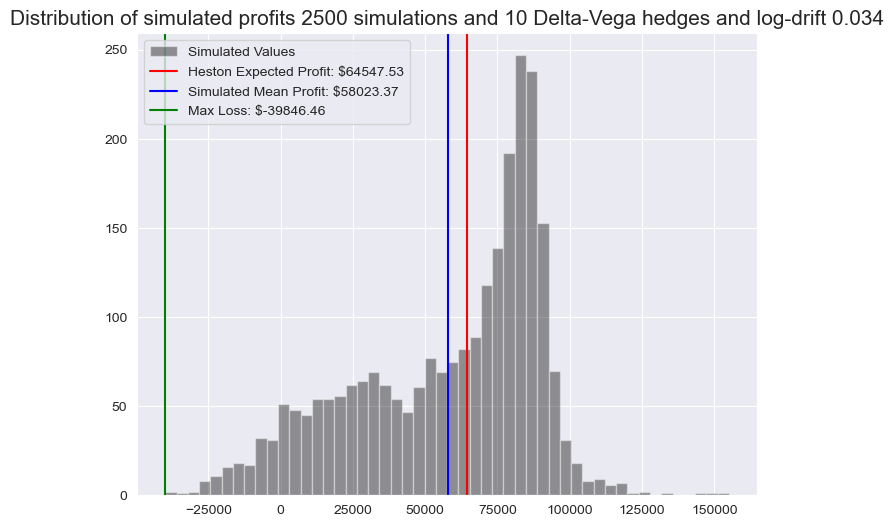

Standard error of Monte-Carlo simulated value of portfolio for Heston model: 0.063252.


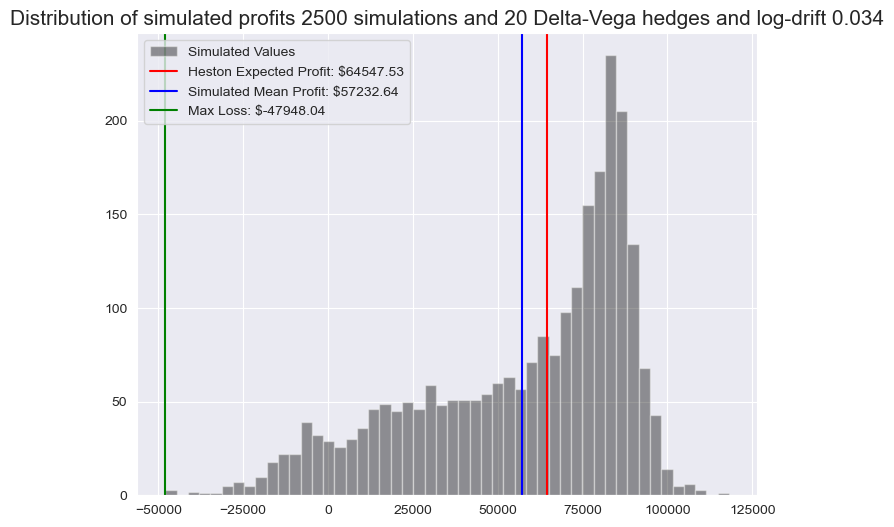

In [44]:
#Monte-Carlo method to simulate price of call option under Heston-Model.
#Compare estimate provided by faster method of numeric integration.

### Visual of stock paths measure simulated through the Heston model


#Heston parameters
kappa = 1 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)
theta = .5**2 #Long run variance of log-returns
xi = .5 # Volatility of Volatility (Typical range .2 to 1)
v0 = .3**2 #Initial variance of log-returns
rho = -.5 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)
S0 = 100 #Initial Stock Value
t = 1 #Time horizon
n_steps = 252 #Number of steps in each simulation
r = .04 #Risk-free interest rate
n_sims = 2500 #Number of simulations
mu = .034 #Excess drift of log returns
K = 90 #Strike Price 1
premium = heston_call(S0, K, v0+0.3, r, t, kappa, theta, xi, rho)

num_options = 10000


#This is the bona fide price of the call option
heston_price = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)


#Due to computational limits we keep small hedging numbers
hedging_numbers = [1,2,5,10,20]


for n_hedges in hedging_numbers:
    sold_calls_hedged = heston_call_vega_hedge_MC(S0, K, v0, r, t, n_hedges, kappa, theta, xi, rho, n_sims, mu=0)
    
    
    heston_call_sim = np.mean(np.mean(sold_calls_hedged))
    heston_std_err = np.std(sold_calls_hedged)/np.sqrt(n_sims)
    print(f'Standard error of Monte-Carlo simulated value of portfolio for Heston model: {heston_std_err:.6f}.')

    profits_hedged = num_options*(premium - sold_calls_hedged)
    plt.figure(figsize = (8,6))
    
    plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
    
    plt.axvline(num_options*(premium-heston_price), label = f'Heston Expected Profit: ${num_options*(premium-heston_price):.2f}', color = 'red')
    
    plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
    plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')
    
    plt.legend()
    
    plt.title(f'Distribution of simulated profits {n_sims} simulations and {n_hedges} Delta-Vega hedges and log-drift {mu}',size = 15)
    
    plt.show()


Maximum loss and standard error are smaller for one hedge, but similar effects are not observed for larger amounts of hedges. It appears that rapidly buying and selling options near strike price near maturity is unstable and is difficult to compute the expected payoff.